# Analyze single objective QAOA results for 42q problem

In [1]:
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from qiskit_optimization.applications import Maxcut
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import GurobiOptimizer
from qiskit_optimization.converters import MaximizeToMinimize

from numba import njit

### Prepare data
Running the following cells requires running QAMOO with MPS and HW first to generate the corresponding `samples.npy` files.

Otherwise, see below to load pre-computed data to generate the figure.

In [2]:
# load samples and weights
problem_folder = '../data/problems/42q/problem_set_42q_0s_3o_0/'
weights_file = '../data/objective_weights/objective_weights_3o_0.json'
results_folder = problem_folder + 'results/'
hw_samples_file = results_folder + 'qaoa_ibm_fez_v2_p_6_5000_samples_5000_shots_f0/samples.npy'
mps_samples_file = results_folder + 'qaoa_aer_simulator_matrix_product_state_v2_p_6_5000_samples_5000_shots_20_0/samples.npy'
figure_results_folder = results_folder + 'single_objective_analysis/'

In [3]:
# load objective weights
with open(weights_file) as f:
    objective_weights = json.load(f)
objective_weights = np.array(objective_weights)

In [4]:
def load_graph(filename):
    with open(filename) as f:
        data = json.load(f)
    return nx.readwrite.json_graph.node_link_graph(data)
    
def load_graphs_from_problem_folder(num_objectives, problem_folder):

    # get objective graphs
    graphs = [
            load_graph(
                problem_folder + f'problem_graph_{idx}.json')
            for idx in range(num_objectives)
        ]    

    # create and return MO-MAXCUT problem
    return graphs

def weighted_graph(weights, graphs):
        edges = {}
        for i in range(len(graphs)):
            for u, v, data in graphs[i].edges(data=True):
                edges[(u, v)] = edges.get((u, v), 0.0) + weights[i]*data['weight']

        wg = nx.Graph()
        for (u, v), w in edges.items():
            wg.add_edge(u, v, weight=w)

        return wg

In [5]:
graphs = load_graphs_from_problem_folder(3, problem_folder)

# construct cost matrices from graphs
n = graphs[0].number_of_nodes()
cost_matrices = []
for i, graph in enumerate(graphs):
    Q = np.zeros((n, n))
    for u, v, data in graph.edges(data=True):
        # w_uv*(x_u + x_v - 2*x_u*x_v)
        Q[u, v] += -data['weight']
        Q[v, u] += -data['weight']
        Q[u, u] += data['weight']
        Q[v, v] += data['weight']
    cost_matrices += [Q]

In [6]:
# utility function to speed up objective function evaluation using numba
@njit(cache=True)
def _eval_loop(samples, cost_matrices=cost_matrices):
    n = len(samples)
    m = len(cost_matrices)
    f_values = np.zeros((n, m))
    for i in range(n):
        x = samples[i]
        f_values[i, :] = [x@Q@x for Q in cost_matrices]
    return f_values
    
def evaluate_objectives(samples, cost_matrices=cost_matrices):
    """evaluate all objective functions for the given samples"""
    return _eval_loop(samples.astype('float64'), cost_matrices)

def evaluate_weighted_objective(samples, weights):
    """for every sample, evaluate the objectives, and compute the weighted sum for the given weights"""
    multi_objective_values = evaluate_objectives(samples)
    return multi_objective_values @ weights

In [7]:
# initialize solver
solver = GurobiOptimizer()

In [8]:
# analyze hardware data
hw_samples = np.load(hw_samples_file)

f_ub = []
f_lb = []
f_max = []
f_min = []
f_avg = []
f_std = []

for i in tqdm(range(5000)):
    
    w = objective_weights[i, :]
    maxcut = Maxcut(weighted_graph(w, graphs))

    # create quadratic program from maxcut problem
    qp_maxcut = maxcut.to_quadratic_program()
    
    # create Ising Hamiltonian and offset from quadratic program
    H, offset = qp_maxcut.to_ising()
    
    # solve quadratic program
    sol_ub = solver.solve(qp_maxcut)
    f_ub += [sol_ub.fval]    
    sol_lb = solver.solve(MaximizeToMinimize().convert(qp_maxcut))
    f_lb += [sol_lb.fval]

    i_start = 5000*i
    i_end = 5000*(i+1)
    fvals = evaluate_weighted_objective(hw_samples[i_start:i_end], w)
    f_max += [max(fvals)]
    f_min += [min(fvals)]
    f_avg += [np.mean(fvals)]
    f_std += [np.std(fvals)]

f_ub = np.array(f_ub)
f_lb = np.array(f_lb)
f_min = np.array(f_min)
f_max = np.array(f_max)
f_avg = np.array(f_avg)
f_std = np.array(f_std)

# compute approximation ratios
spread = f_ub - f_lb
cdf_ar_max = np.sort((f_max - f_lb) / spread)
cdf_ar_min = np.sort((f_min - f_lb) / spread)
cdf_ar_avg = np.sort((f_avg - f_lb) / spread)
cdf_ar_std_l = np.sort((f_avg - f_std - f_lb) / spread)
cdf_ar_std_u = np.sort((f_avg + f_std - f_lb) / spread)

  0%|          | 0/5000 [00:00<?, ?it/s]

Restricted license - for non-production use only - expires 2025-11-24


In [9]:
mps_samples = np.load(mps_samples_file)

f_max_mps = []
f_min_mps = []
f_avg_mps = []
f_std_mps = []

for i in tqdm(range(5000)):
    
    w = objective_weights[i, :]

    i_start = 5000*i
    i_end = 5000*(i+1)
    fvals = evaluate_weighted_objective(mps_samples[i_start:i_end], w)
    f_max_mps += [max(fvals)]
    f_min_mps += [min(fvals)]
    f_avg_mps += [np.mean(fvals)]
    f_std_mps += [np.std(fvals)]

f_min_mps = np.array(f_min_mps)
f_max_mps = np.array(f_max_mps)
f_avg_mps = np.array(f_avg_mps)
f_std_mps = np.array(f_std_mps)

# compute approximation ratios
cdf_ar_max_mps = np.sort((f_max_mps - f_lb) / spread)
cdf_ar_min_mps = np.sort((f_min_mps - f_lb) / spread)
cdf_ar_avg_mps = np.sort((f_avg_mps - f_lb) / spread)
cdf_ar_std_l_mps = np.sort((f_avg_mps - f_std_mps - f_lb) / spread)
cdf_ar_std_u_mps = np.sort((f_avg_mps + f_std_mps - f_lb) / spread)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [10]:
# generate random samples
rnd_samples = np.round(np.random.rand(25_000_000, 42))

# analyze random samples
f_avg_rnd = []
for i in tqdm(range(5000)):
    
    w = objective_weights[i, :]

    i_start = 5000*i
    i_end = 5000*(i+1)
    fvals = evaluate_weighted_objective(rnd_samples[i_start:i_end], w)
    f_avg_rnd += [np.mean(fvals)]

f_avg_rnd = np.array(f_avg_rnd)

# compute average approximation ratio
rnd_avg_ar = np.mean((f_avg_rnd - f_lb) / spread)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [11]:
# save data to files
np.save(figure_results_folder + 'cdf_ar_max.npy', cdf_ar_max)
np.save(figure_results_folder + 'cdf_ar_min.npy', cdf_ar_min)
np.save(figure_results_folder + 'cdf_ar_avg.npy', cdf_ar_avg)
np.save(figure_results_folder + 'cdf_ar_std_l.npy', cdf_ar_std_l)
np.save(figure_results_folder + 'cdf_ar_std_u.npy', cdf_ar_std_u)

np.save(figure_results_folder + 'cdf_ar_max_mps.npy', cdf_ar_max_mps)
np.save(figure_results_folder + 'cdf_ar_min_mps.npy', cdf_ar_min_mps)
np.save(figure_results_folder + 'cdf_ar_avg_mps.npy', cdf_ar_avg_mps)
np.save(figure_results_folder + 'cdf_ar_std_l_mps.npy', cdf_ar_std_l_mps)
np.save(figure_results_folder + 'cdf_ar_std_u_mps.npy', cdf_ar_std_u_mps)

np.save(figure_results_folder + 'rnd_avg_ar.npy', rnd_avg_ar)

## Load pre-computed data

In [12]:
# load pre-computed data from files
cdf_ar_max = np.load(figure_results_folder + 'cdf_ar_max.npy')
cdf_ar_min = np.load(figure_results_folder + 'cdf_ar_min.npy')
cdf_ar_avg = np.load(figure_results_folder + 'cdf_ar_avg.npy')
cdf_ar_std_l = np.load(figure_results_folder + 'cdf_ar_std_l.npy')
cdf_ar_std_u = np.load(figure_results_folder + 'cdf_ar_std_u.npy')

cdf_ar_max_mps = np.load(figure_results_folder + 'cdf_ar_max_mps.npy')
cdf_ar_min_mps = np.load(figure_results_folder + 'cdf_ar_min_mps.npy')
cdf_ar_avg_mps = np.load(figure_results_folder + 'cdf_ar_avg_mps.npy')
cdf_ar_std_l_mps = np.load(figure_results_folder + 'cdf_ar_std_l_mps.npy')
cdf_ar_std_u_mps = np.load(figure_results_folder + 'cdf_ar_std_u_mps.npy')

rnd_avg_ar = np.load(figure_results_folder + 'rnd_avg_ar.npy')

## Plot results

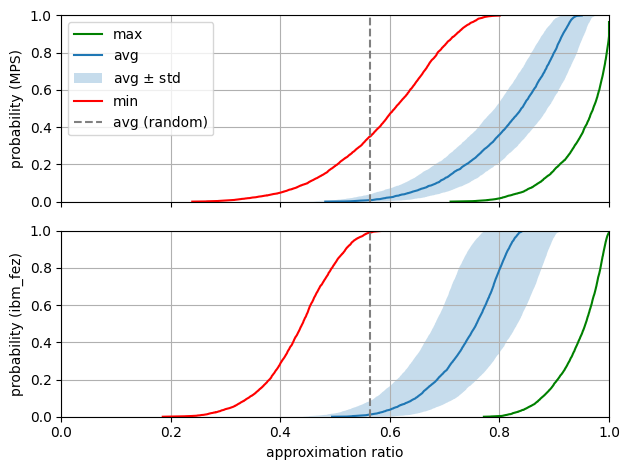

In [13]:
plt.subplots(2, 1, sharex=True)

plt.subplot(2, 1, 1)

plt.plot(cdf_ar_max_mps, np.linspace(0, 1, len(cdf_ar_max_mps)), 'g-', label='max')
plt.plot(cdf_ar_avg_mps, np.linspace(0, 1, len(cdf_ar_max_mps)), '-', label='avg')
plt.fill_betweenx(np.linspace(0, 1, len(cdf_ar_std_l_mps)), cdf_ar_std_l_mps, cdf_ar_std_u_mps, alpha=0.25, label=r'avg $\pm$ std')
plt.plot(cdf_ar_min_mps, np.linspace(0, 1, len(cdf_ar_min_mps)), 'r-', label='min')
plt.vlines(rnd_avg_ar, 0, 1, colors='gray', linestyles='--', label='avg (random)')

plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
plt.ylabel('probability (MPS)')


plt.subplot(2, 1, 2)

plt.plot(cdf_ar_max, np.linspace(0, 1, len(cdf_ar_max)), 'g-', label='max')
plt.plot(cdf_ar_avg, np.linspace(0, 1, len(cdf_ar_max)), '-', label='avg')
plt.fill_betweenx(np.linspace(0, 1, len(cdf_ar_std_l)), cdf_ar_std_l, cdf_ar_std_u, alpha=0.25, label=r'avg $\pm$ std')
plt.plot(cdf_ar_min, np.linspace(0, 1, len(cdf_ar_min)), 'r-', label='min')
plt.vlines(rnd_avg_ar, 0, 1, colors='gray', linestyles='--', label='avg (random)')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
plt.xlabel('approximation ratio')
plt.ylabel(r'probability (ibm_fez)')
           
plt.tight_layout()
plt.savefig('../../qamoo/figures/42q_3o_p_6_single_objective.pdf')
plt.show()